# Exploratory Data Analysis and Feature Engineering

In [167]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS 
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [63]:
stemmed_data = pd.read_csv('data/stemmed_clean_data')
lemmatized_data = pd.read_csv('data/lemmatized_clean_data')

In [4]:
lemmatized_data.head()

,title,body,label
0,house dem aide even see comey letter jason cha...,house dem aide even see comey letter jason cha...,1
1,flynn hillary clinton big woman campus breitbart,ever get feeling life circle roundabout rather...,0
2,truth might get fired,truth might get fired october 29 2016 tension ...,1
3,15 civilian killed single u airstrike identified,video 15 civilian killed single u airstrike id...,1
4,iranian woman jailed fictional unpublished sto...,print iranian woman sentenced six year prison ...,1


## WordClouds

In [20]:
# Making a wordcloud :  https://www.geeksforgeeks.org/generating-word-cloud-python/

def make_wordcloud(dataframe, col, fig_title=None):
    
    """
    The function makes a wordcloud for a given column in a dataframe that contains text
    
    Params: 
        dataframe: The dataframe to operate on
        col: a string containg the name of the column
        
    Output: 
        Prints a wordcloud
    """
    
    comment_words = '' 
    stopwords = set(STOPWORDS) 

    # iterate through the csv file 
    for val in dataframe[col]: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (12,8), facecolor = None) 
    plt.title(fig_title)
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

In [8]:
# Separating the fake and true articles
# For the wordcloud, i'll only be using the lemmatized data as the words in the lemmatized data are actual words unlike the words we'd encounter in the stemmed dataset

data_fake = lemmatized_data[lemmatized_data['label'] == 1]  # All the fake points 
data_true = lemmatized_data[lemmatized_data['label'] == 0]  # All the true points

### Titles

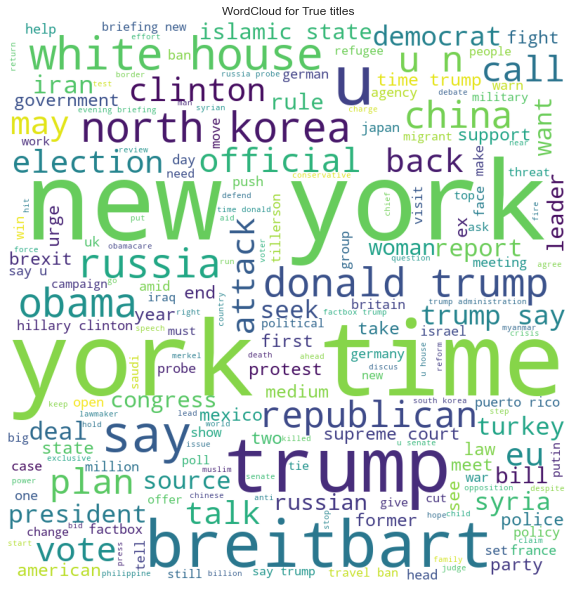

In [22]:
# Plotting the wordcloud for all the titles coming from the true/legitimate articles

make_wordcloud(data_true,'title', 'WordCloud for True titles')

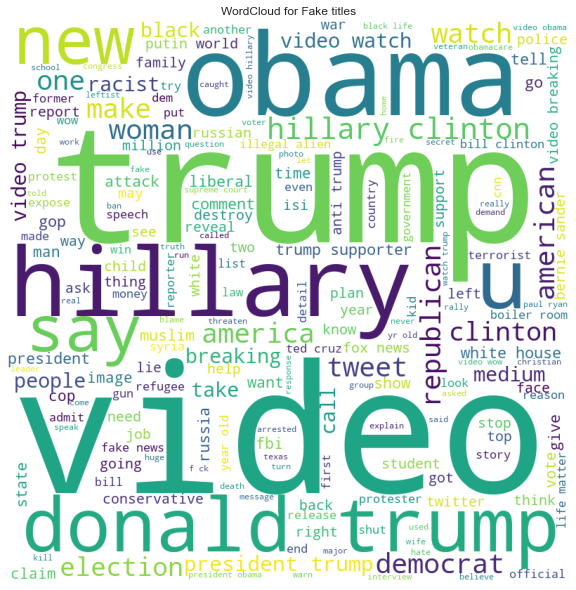

In [23]:
# Plotting the wordcloud for all the titles coming from the fake articles

make_wordcloud(data_fake,'title', 'WordCloud for Fake titles')

### Articles

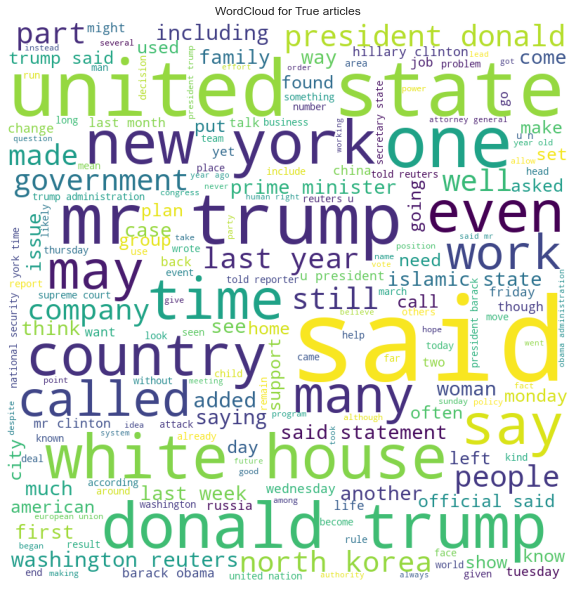

In [24]:
# Plotting the wordcloud for all the articles coming from the true/legitimate articles

make_wordcloud(data_true,'body', 'WordCloud for True articles')

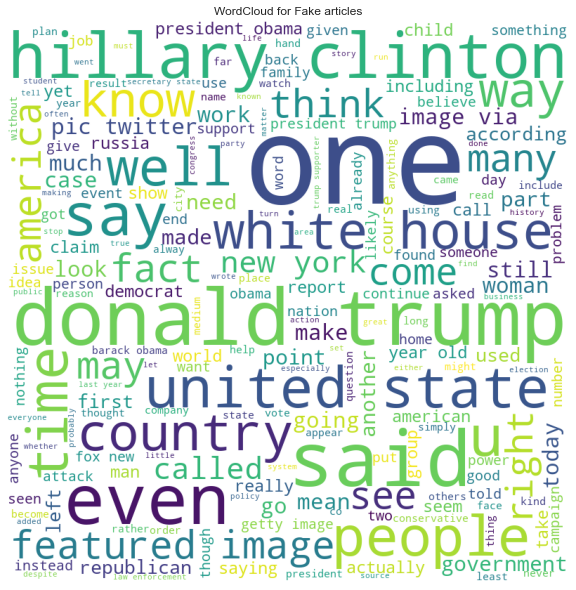

In [25]:
# Plotting the wordcloud for all the articles coming from the fake articles

make_wordcloud(data_fake,'body', 'WordCloud for Fake articles')

## Observations:
* We can see that names like Donald Trump occur a lot in both Fake and True news articles. Whereas names like Hillary Clinton occur more often in Fake news articles
* From the wordclouds it is very clear that the data is heavily centered around politics and perhaps even more around the 2016 US elections

In [68]:
# Even after previously filling out missing data, somehow 700 missing articles have come about. This could have happened because of stemming / lemmatization
# Getting rid of the missing points

stemmed_data = stemmed_data.dropna()
lemmatized_data = lemmatized_data.dropna()

## Train Test Split

In [70]:
# Spliting the data to avoid any sort of data leakage
# The use of random_seed = 42 will be maintained throughout the case study in order to have the same train test splits throughout


X_stemmed, X_lemmatized = stemmed_data.drop('label',axis=1), lemmatized_data.drop('label',axis=1)
y_stemmed, y_lemmatized = stemmed_data['label'], lemmatized_data['label']

# Train test split for the stemmed data
X_stemmed_train, X_stemmed_test, y_stemmed_train, y_stemmed_test = train_test_split(X_stemmed, y_stemmed, test_size=0.2, random_state=42,stratify=y_stemmed)  

# Train test split for the lemmatized data
X_lemm_train, X_lemm_test, y_lemm_train, y_lemm_test = train_test_split(X_lemmatized, y_lemmatized, test_size=0.2, random_state=42, stratify=y_lemmatized)

In [71]:
# Adding back the labels to the training data

X_stemmed_train['label'] = y_stemmed_train
X_lemm_train['label'] = y_lemm_train

In [72]:
X_stemmed_train.head()

,title,body,label
49668,militari expert vow take trump challeng,donald trump like bulli love talk crap victim ...,1
9043,dutert promis china not even one gun south chi...,philippin presid rodrigo dutert shock intern o...,0
39082,ukrain anti corrupt bureau launch case sister ...,kiev reuter ukrainian investig tuesday said op...,0
18533,secur polit close open societi,email increas symbiosi polit lead mainstream m...,1
38377,south africa zuma appoint perman polic commission,johannesburg reuter south african presid jacob...,0


In [73]:
X_lemm_train.head()

,title,body,label
49668,military expert vow take trump challenge,donald trump like bully love talk crap victim ...,1
9043,duterte promise china not even one gun south c...,philippine president rodrigo duterte shocked i...,0
39082,ukraine anti corruption bureau launch case sis...,kiev reuters ukrainian investigator tuesday sa...,0
18533,security politics closing open society,email increasing symbiosis political leading m...,1
38377,south africa zuma appoints permanent police co...,johannesburg reuters south african president j...,0


## Title and Article lengths

In [74]:
# Defining a function that gets lengths of all instances in a series (title and body for instance)
# While the same task can simply be achieved using a simply apply(len) function on the feature whose length be want, it fails when there are NaN values. 

def get_length(series):
    
    """
        Given a series, the function returns the number of words for all instances in the series in a list. 
        This function works well even when NaNs are present in the series.
        
        Parameter: Takes in a series that contains text data.
        
        Output: Returns a lists such which contains the number of words per sentence 
    """
    
    series_list = series.values # Converting the series to a list
    total_words = []   # List to store all the lengths. Here length refers to the number of words in each sentence

    for sentence in series_list:
        # Checking whether the sentence is np.nan. Since we're dealing with text data, the only case where the type of a sentence would be float is when its NaN
        if type(sentence) == float:   
            total_words.append(np.nan)
        else: 
            total_words.append(len(sentence.split()))  # Length of the sentence as in number of words in the sentence
            
    return total_words

In [75]:
# For the stemmed data

title_num_words = get_length(X_stemmed_train['title'])
body_num_words = get_length(X_stemmed_train['body'])

X_stemmed_train['title_word_count'] = title_num_words
X_stemmed_train['body_word_count'] = body_num_words

# For the lemmatized data

title_num_words = get_length(X_lemm_train['title'])
body_num_words = get_length(X_lemm_train['body'])

X_lemm_train['title_word_count'] = title_num_words
X_lemm_train['body_word_count'] = body_num_words

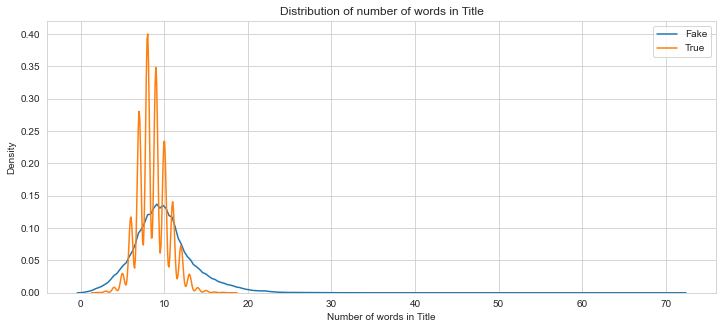

In [92]:
# Plotting distributions of fake and true articles and titles based on count of words
# For plotting and analysis, i'll only use the lemmatized data since it'll mostly be the same for the stemmed data

X_lemm_fake = X_lemm_train[X_lemm_train['label'] == 1]
X_lemm_true = X_lemm_train[X_lemm_train['label'] == 0]

plt.figure(figsize=(12,5))
sns.kdeplot(X_lemm_fake['title_word_count'], label='Fake')
sns.kdeplot(X_lemm_true['title_word_count'], label='True')

plt.xlabel('Number of words in Title')
plt.title('Distribution of number of words in Title')

plt.legend()
plt.plot()
plt.show()

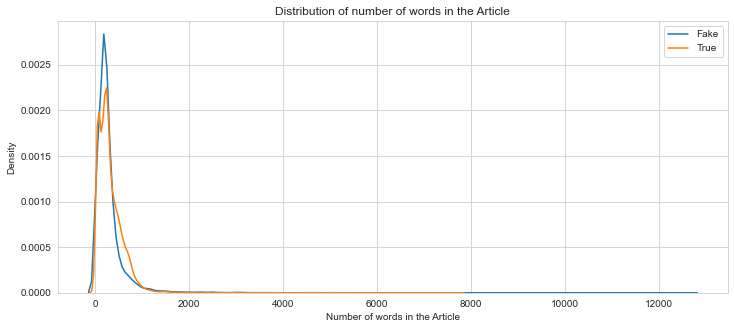

In [94]:
# Plotting distributions of fake and true articles and titles based on count of words

plt.figure(figsize=(12,5))
sns.kdeplot(X_lemm_fake['body_word_count'], label='Fake')
sns.kdeplot(X_lemm_true['body_word_count'], label='True')

plt.xlabel('Number of words in the Article')
plt.title('Distribution of number of words in the Article')


plt.legend()
plt.plot()
plt.show()

In [100]:
print(X_lemm_true['body_word_count'].mean())
print(X_lemm_fake['body_word_count'].mean())

324.0468889218889
288.90438003452243


 Its pretty evident that the number of words in an article or title are not good at all to separate classes, we can analyse if points that are outliers in terms of word count have any impact on the class labels

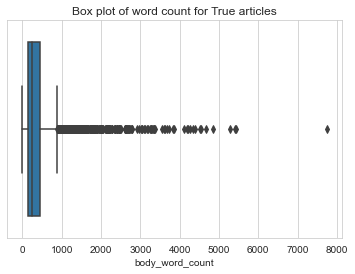

In [152]:
# Checking if outliers have

sns.boxplot(X_lemm_true['body_word_count'], whis=1.5)
plt.title('Box plot of word count for True articles')
plt.show()

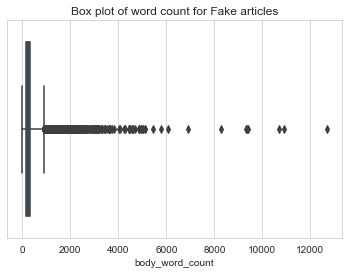

In [153]:
sns.boxplot(X_lemm_fake['body_word_count'], whis=3)
plt.title('Box plot of word count for Fake articles')
plt.show()

In [154]:
def get_outliers(data, col, mul=1.5):
    
    """
    This function computes the upper and lower bounds that determine whether a point is an outlier or not.
    Returns: A dataframe containing all the outlier points
    
    """
    
    q1 = np.quantile(data[col], 0.25)  # 1st quartile
    q3 = np.quantile(data[col], 0.75)  # 3rd quartile
    
    iqr = q3 - q1
    
    lower_bound = q1 - (mul * iqr)
    upper_bound = q3 + (mul * iqr)
    
    outlier_pts = data[(data[col] > upper_bound) | (data[col] < lower_bound)]
    
    return (upper_bound, lower_bound, outlier_pts)

In [163]:
upper, lower, outlier_X_lemm = get_outliers(X_lemm_train, col='body_word_count',mul= 1.5)

In [164]:
# Printing how many outliers belong to each class

outlier_X_lemm['label'].value_counts()

0    1600
1    1519
Name: label, dtype: int64

From this too we can see that outlier points probably have no impact on the class label. And to some extent that makes sense since articles regardless of whether they are fake or not vary in length. Some are really small whereas some are big. <br> This suggests us that the word count feature and any features built on top of it might not be good at all

## Using Sentiment scores
NLTK has a nice sentiment analysis tool called Vader lexicon sentiment. Given some text, it retuns 4 scores. They are: 
* positive 
* negative
* neutral
* compoud

We can obtain these scores for all the articles and see if that helps us separating the class labels

In [273]:
# An example of how the vader lexicon sentiment works

text = 'It is such a good day today. I feel happy'

sentiment = SentimentIntensityAnalyzer()

sentiment.polarity_scores(text)

{'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'compound': 0.765}

In [189]:
# Function that generates sentiment scores for all the datapoints 

def get_sentiment_scores(data, col):
    
    """
    Given the dataframe and the column, the fucntion returns sentiment scores. Gives 4 scores of negtaive, neutral, positive and composite.
    """
    # Initializing lists to store the sentiment scores of all points
    neg = []
    neu = []
    pos = []
    comp = []
    
    sentiment = SentimentIntensityAnalyzer() # Initializing the analyzer
    
    for sentence in tqdm((data[col].values)):
        
        sentiment_dict = sentiment.polarity_scores(sentence)
        
        neg.append(sentiment_dict.get('neg'))
        neu.append(sentiment_dict.get('neu'))
        pos.append(sentiment_dict.get('pos'))
        comp.append(sentiment_dict.get('compound'))
        
    
    return (neg, neu, pos, comp)

In [190]:
# Getting the sentiment scores for only the articles since the titles are really short

neg, neu, pos, comp = get_sentiment_scores(X_lemm_train, 'body')

X_lemm_train['neg'] = neg
X_lemm_train['neu'] = neu
X_lemm_train['pos'] = pos
X_lemm_train['comp'] = comp

X_lemm_train.head()

100%|███████████████████████████████████████████████████████████████████████████| 54744/54744 [02:54<00:00, 314.20it/s]


,title,body,label,title_word_count,body_word_count,neg,neu,pos,comp
49668,military expert vow take trump challenge,donald trump like bully love talk crap victim ...,1,6,339,0.173,0.695,0.133,-0.9626
9043,duterte promise china not even one gun south c...,philippine president rodrigo duterte shocked i...,0,12,340,0.049,0.739,0.212,0.9953
39082,ukraine anti corruption bureau launch case sis...,kiev reuters ukrainian investigator tuesday sa...,0,8,266,0.142,0.684,0.174,0.7565
18533,security politics closing open society,email increasing symbiosis political leading m...,1,5,255,0.274,0.551,0.175,-0.9900
38377,south africa zuma appoints permanent police co...,johannesburg reuters south african president j...,0,7,125,0.242,0.671,0.087,-0.9794


In [192]:
X_lemm_fake = X_lemm_train[X_lemm_train['label'] == 1]
X_lemm_true = X_lemm_train[X_lemm_train['label'] == 0]

### Seeing how effective these scores are

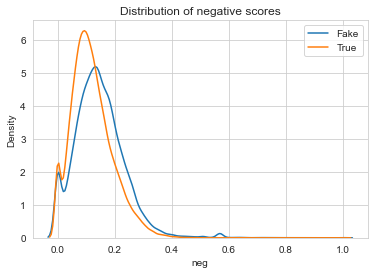

In [227]:
sns.kdeplot(X_lemm_fake['neg'],label='Fake')
sns.kdeplot(X_lemm_true['neg'],label='True')
plt.title('Distribution of negative scores')
plt.legend();

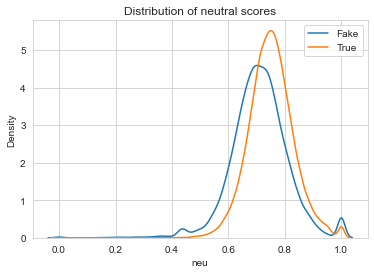

In [213]:
sns.kdeplot(X_lemm_fake['neu'],label='Fake')
sns.kdeplot(X_lemm_true['neu'],label='True')
plt.title('Distribution of neutral scores')
plt.legend();

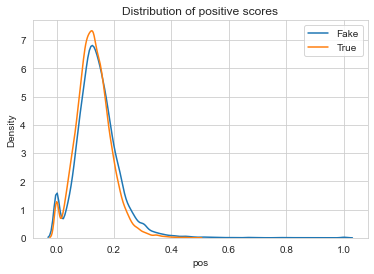

In [207]:
sns.kdeplot(X_lemm_fake['pos'],label='Fake')
sns.kdeplot(X_lemm_true['pos'],label='True')
plt.title('Distribution of positive scores')
plt.legend();

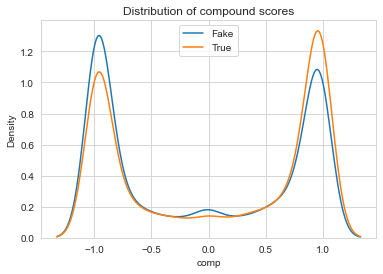

In [233]:
sns.kdeplot(X_lemm_fake['comp'],label='Fake')
sns.kdeplot(X_lemm_true['comp'],label='True')
plt.title('Distribution of compound scores')
plt.legend();

These scores too aren't really helping at all in separating the class labels

## Creating features for the test set

In [253]:
#X_lemm_test, y_lemm_test

# For the lemmatized data

title_num_words = get_length(X_lemm_test['title'])
body_num_words = get_length(X_lemm_test['body'])

X_lemm_test['title_word_count'] = title_num_words
X_lemm_test['body_word_count'] = body_num_words

neg, neu, pos, comp = get_sentiment_scores(X_lemm_test, 'body')

X_lemm_test['neg'] = neg
X_lemm_test['neu'] = neu
X_lemm_test['pos'] = pos
X_lemm_test['comp'] = comp

100%|███████████████████████████████████████████████████████████████████████████| 13686/13686 [00:42<00:00, 325.82it/s]


In [254]:
X_lemm_test.head()

,title,body,title_word_count,body_word_count,neg,neu,pos,comp
54976,sheila jackson lee get msnbc host conyers let ...,conversation msnbc host craig melvin got heate...,10,198,0.187,0.738,0.075,-0.9728
63392,house lie pedophilia allegation levied anti tr...,gay community feel trump hating actor bill cli...,14,500,0.129,0.714,0.158,0.9371
58498,terminally ill former miss wi last breath use ...,sean hannity medium personality able find amaz...,14,48,0.099,0.636,0.265,0.9099
52310,white house defends boehner lucifer comment cr...,ever since former house speaker john boehner a...,10,185,0.099,0.634,0.266,0.9876
32298,hillary clinton spar comedian parody talk show...,los angeles reuters democratic presidential no...,8,171,0.032,0.792,0.176,0.9770


In [268]:
X,y = X_lemm_test.drop(['title','body'],axis=1), y_lemm_test

In [269]:
from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()

X = scaler.transform(X)

In [265]:
from sklearn.svm import SVC

clf = SVC()

clf.fit(X,y)

SVC()

In [270]:
y_pred = clf.predict(X)

In [271]:
(y_pred==y).sum() /len(y)

0.711968434896975

## Takeaways
* Using these simple and basic features, a simple Logistic Regression model achieves an accuracy score of around 63%.
* Similarly SVM achieves upto 71%. One thing to note is that because of the size of the training data, it took a lot of time to train the SVC model and using an SVM on top of these features and combined with the featurized test features will be highly impractical and time consuming.
* From the analysis, its pretty evident that these features aren't doing a great job of separating the distributions of the two classes. But they can be used along with the final model if need be.